# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [38]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import re
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

# Function for feature building and extraction on natural language data

In [60]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
#     toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
#     toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")
    toxic_data['ep_count'] = toxic_data['comment_text'].str.count("\!")
    toxic_data['hell_count'] = toxic_data['comment_text'].str.count("hell") + toxic_data['comment_text'].str.count("HELL") #str.lower() threw an error
    toxic_data['upper_ratio'] = toxic_data['comment_text'].str.count(r'[A-Z]')#/toxic_data['comment_text'].str.count("\.") #other ways re.findall and looping with isupper returned the same value for each row

#     X_quant_features = toxic_data[["word_count", "punc_count"]]
    X_quant_features = toxic_data[["ep_count", "hell_count", "upper_ratio"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [61]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='C:/Users/agbro/Documents/machine-learning/toxiccomments_train.csv', my_random_seed=22)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [62]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 12916, 'Neg': 114740, 'TP': 6840, 'TN': 56124, 'FP': 58616, 'FN': 6076, 'Accuracy': 0.49323181049069376, 'Precision': 0.10449767782938157, 'Recall': 0.5295757200371632, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [63]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 12916, 'Neg': 114740, 'TP': 12329, 'TN': 113802, 'FP': 938, 'FN': 587, 'Accuracy': 0.9880538321739676, 'Precision': 0.9292982588377177, 'Recall': 0.9545524930318984, 'desc': 'svm_train'}


### MODEL: logistic regression

In [64]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 12916, 'Neg': 114740, 'TP': 12310, 'TN': 113803, 'FP': 937, 'FN': 606, 'Accuracy': 0.987912828225857, 'Precision': 0.9292670038499283, 'Recall': 0.9530814493651285, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [65]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 12916, 'Neg': 114740, 'TP': 12653, 'TN': 103515, 'FP': 11225, 'FN': 263, 'Accuracy': 0.9100081468947797, 'Precision': 0.5299020018427004, 'Recall': 0.9796376587178693, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [66]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

C:\Users\agbro\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


{'Pos': 12916, 'Neg': 114740, 'TP': 12281, 'TN': 113808, 'FP': 932, 'FN': 635, 'Accuracy': 0.9877248229617096, 'Precision': 0.9294634072504352, 'Recall': 0.9508361721895323, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [67]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 12916, 'Neg': 114740, 'TP': 10868, 'TN': 114555, 'FP': 185, 'FN': 2048, 'Accuracy': 0.9825076768816193, 'Precision': 0.9832624626798154, 'Recall': 0.8414369773923815, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [68]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

C:\Users\agbro\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Pos': 12916, 'Neg': 114740, 'TP': 0, 'TN': 114740, 'FP': 0, 'FN': 12916, 'Accuracy': 0.8988218336780096, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_train'}


C:\Users\agbro\Documents\machine-learning\my_measures.py:25: RuntimeWarning: invalid value encountered in longlong_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### ROC plot to compare performance of various models and fits

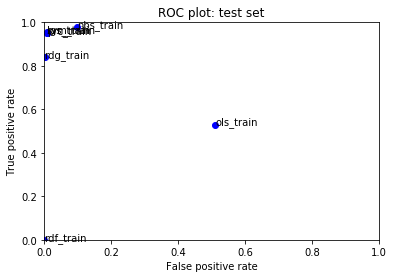

In [69]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [70]:
ols_predictions = ols.predict(X_train)

In [71]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
11
Please do not add unsourced or original content. Doing so violates Wikipedia's verifiability policy. If you would like to experiment, please use the sandbox. Thank you.  You can not use a reference that states the opposite of your POV and call it a reference. Please refrain from adding your personal POV to articles. 199.125.109.103
* * * * * * * * * 
35
"

There's really no reason to use quotation marks, unless there is a doubt that Satanism is indeed a religion.  talk "
* * * * * * * * * 
38
, 3 March 2008 (UTC)
Ah, but I have a free ticket! (Seriously!) Anyway, you might like to look at this. The Old Farm has come out as the second most intense rivalry in English football! (I can't currently access that url)   12:05
* * * * * * * * * 
60
"
 I concur with the direction the discussion has gone, though my only supplementary input at this time is that I think the move should be to Planet Pop (A Touch of Class album), since that's where the band's article i

1596
Y r we doing this: Pat
* * * * * * * * * 
1598
No apology in that of course! too much to expect...well where is the article on drug dynamization as of yesterday lost in cyberspace or what? OK Filll proceed and try to keep this wrecker on a short leash please Peter morrell
* * * * * * * * * 
1613
Hello! Some of the people, places or things you have written about in the article Nikolas Tryfonos may not be sufficiently well-known to merit articles of their own. The Wikipedia community welcomes newcomers, and encourages them to become Wikipedians. On Wikipedia, each user is entitled to a user page in which they can describe themselves, and this article's content may be incorporated into that page. However, to merit inclusion in the encyclopedia proper, a subject must be notable. We encourage you to write or improve articles on notable subjects.    tock
* * * * * * * * * 
1648
Hi Kenway! 

Have a great day today. I know I shall, it's been a gas ). 

Nice town. 81.17.18.209
* * * * * * 

2770
Racism, look it up.
* * * * * * * * * 
2845
Piotrus' and propaganda
* * * * * * * * * 
2886
Cornell qatar courtyard.jpg|thumbnail|File:Cornell qatar courtyard
* * * * * * * * * 
2912
Infobox 

You left a comment at the infobox debate but it wasn't clear if you were !voting to keep or to have it deleted.
* * * * * * * * * 
2915
"

 Advertisement 

Since when did Wikipedia advertise? 

""Wakestock is Europe's largest wakeboard music festival, combining the cultures of music and the world's fastest growing watersport in a weekend of high-octane excitement!"""
* * * * * * * * * 
2936
"

Hello,
Can you please find Iran's pre-rev. flag and post it on the ""flag of iran"" section becasue it is not there. I can't fint it anywhere on the net. 
Thanks"
* * * * * * * * * 
2945
Well that's perfectly reasonable. Thank you.
* * * * * * * * * 
3054
"

Please take a look to ;Defterdar Mosque needs attention. Did you read Cumhuriyet today, page 15; ""KULE CAMBAZI""-Sunay Akın.T  C  "
* * * * * * *

4038
"

Thankyou, TheIndividualist and Intangible. duck talk 

FrancisTyers moving my edit to another article

That was real cute, FrancisTyers, moving my edit to another article thereby getting it out of the way of this communisto-anarchist article and taking credit for my research at the same time. Clever. BTW, how many edits did you make on Sunday the 23rd, Francis? Let me count..uh 1, 2, 3, 4....9 edits in one day. You could get blocked for that if I'm not mistaken. I may be wrong but I believe there's a WP:3RR rule. Oh well, happy editing! duck talk "
* * * * * * * * * 
4102
"

""The ""Laws and Constitutions of the Loyal Orange Institution of Scotland"", 1986 state: ""No ex-Roman Catholic will be admitted into the Institution unless he is a Communicant in a Protestant Church for a reasonable period."" Likewise the ""Constitution, Laws and Ordinances of the Loyal Orange Institution of Ireland"" (1967) state: ""No person who at any time has been a Roman Catholic.... shall be admitte

5464
User pages 

I wasn't even aware of that category being there, and it took me awhile to figure out where it came from. Having done that, I deleted it. So your deletion was correct, but your approach was incorrect. Unless someone has something extremely gross or vile or otherwise rule-violating on their page, don't mess with it yourself - ask the user first. ← What's up, Doc? carrots→
* * * * * * * * * 
5495
Historicism has been held pretty much the same from antique through Medieval through modern times. (There were a few outliers at first.)  It's not until you get to the Counter-Reformation that you begin to get large promotion of Futurism and Preterism (both of which were invented and designed by Jesuits as a specific challenge to protestant Historicism).  Its interesting the Catholic Futurism and Modern Critical Scholarship find their basis in Porphyry a pagan philosopher who railed against Christianity and especially against Bible prophecy in the 4th century.  I don't find it 

6972
"

National Broad Left
A ""{{prod}}"" template has been added to the article National Broad Left, suggesting that it be deleted according to the proposed deletion process. All contributions are appreciated, but yours may not satisfy Wikipedia's criteria for inclusion, and the deletion notice explains why (see also ""What Wikipedia is not"" and Wikipedia's deletion policy).  You may contest the proposed deletion by removing the {{dated prod}} notice, but please explain why you disagree with the proposed deletion in your edit summary or on its talk page. Also, please consider improving the article to address the issues raised. Even though removing the deletion notice will prevent deletion through the proposed deletion process, the article may still be deleted if it matches any of the speedy deletion criteria or it can be sent to Articles for Deletion, where it may be deleted if consensus to delete is reached.   -(answering machine) "
* * * * * * * * * 
6998
"
Now that is a heavily b

8629
Incorrect. Check  the diff again.
* * * * * * * * * 
8682
"Hello, and welcome to Wikipedia!

I hope not to seem unfriendly or make you feel unwelcome, but I noticed your username, and I am concerned that it might not meet Wikipedia's username policy for the following reason: your username contains the potentially objectionable word 'torture'. After you look over that policy, could we discuss that concern here?

I'd appreciate learning your own views, for instance your reasons for wanting this particular name, and what alternative username you might accept that avoids raising this concern.

You have several options freely available to you:
 If you can relieve my concern through discussing it here, I can stop worrying about it.
 If the two of us can't agree here, we can ask for help through Wikipedia's dispute resolution process, such as requesting comments from other Wikipedians.  Wikipedia administrators usually abide by agreements reached through this process.
 You can keep your 

10142
As I see the same quote is also present in this book.
* * * * * * * * * 
10184
Filter 

Hi JPS. There is a filter prohibiting me from labelling you as a paedophile. Please remove it. Thanks 79.75.171.79
* * * * * * * * * 
10312
I didn't accuse the other editor of being a biologist.  BI's Talk page states he/she is a biologist.  The reference to BI's background was simply an attempt to compare sources and their respective reliability.  In any case, thank you for your time, I will post on the WP:DRN. 72.199.145.35
* * * * * * * * * 
10374
"

Speedy deletion of Coalition for animal concerns
 A tag has been placed on Coalition for animal concerns, requesting that it be speedily deleted from Wikipedia. This has been done under section G11 of the criteria for speedy deletion, because the article seems to be blatant advertising which only promotes a company, product, group, service or person and would need to be fundamentally rewritten in order to become an encyclopedia article. Please 

11891
JFTR let me post here the link to the latest ban consensus: Wikipedia:Administrators'_noticeboard/IncidentArchive850#Velebit.
* * * * * * * * * 
11903
Mexico city articles 

Youre popping up all over my watchlist. Thanks for doing some much-needed maintanance!!!!
* * * * * * * * * 
12028
I was wondering the same thing.
* * * * * * * * * 
12110
you have been reported 

i reported you on the noticeboard. i am new to wiki and all of its ways, but i know i am in the right, and that you need to quit vandalizing the page that relates to me, personally. go away, please.
* * * * * * * * * 
12155
Hooray! 

Glad you're back! I hope you had a good time on your vacation. )
* * * * * * * * * 
12163
"

 Samoa mo Samoa - Mata Usi Wikipedia 

Samoa (i/səˈmoʊ.ə/; Samoan: Sāmoa, IPA: [ˌsaːˈmoa]), officially the Independent State of Samoa (Samoan: Malo Sa'oloto Tuto'atasi o Sāmoa), formerly known as Western Samoa, is a country encompassing the western part of the Samoan Islands in the South Pacific

14000
people from Tucson are the experts on Tucson 

Once again, my name is Carlos Romero and Tucson is my home. i came here today to stick up for josh and now i am sticking up for myself and my home. I never in my life have tried to hurt or vandalize Germany. You are invading my home town, you are insulting a well know community leader in Joshua Jude Chesser. U are beyond vandal at this point, ur simply wrong & out of ur element. Joshua Jude dosnt even have to replace his own stuff now, im puting together a Tucson task force to respond to the German vandal situation. We represent Tucson, leave us and our home alone you stalker.
* * * * * * * * * 
14037
"

I do believe it is in the best interest of the reader that all articles are justified and does not ""gum up the works.""  In any case, I also believe it's rude to demand things of someone you do not know, especially when there is no official policy stating either case.  I've combed through that summary multiple times, and I'm pretty 

15516
Your edit to Capital punishment 

Thank you for experimenting with Wikipedia. Your test worked, and it has been reverted or removed. Please use the sandbox for any other tests you want to do. Take a look at the welcome page if you would like to learn more about contributing to our encyclopedia.+ R/W
* * * * * * * * * 
15564
[]
This book is my source.
* * * * * * * * * 
15637
"The historians you ""quote"" are not remotely well known enough to have the final say. "
* * * * * * * * * 
15654
I didn't make a threat. I said I'm not going to block you. And you don't need to apologize to me; I was suggesting you apologize to the user whose edit you reverted, in the link I gave you above. That user asked me to block you. Since I'm not going to do that, because after talking it over I can see that your intentions are good, it wouldn't kill you to drop them a line to apologize for your mistake. It doesn't cost you anything. You'll gain a lot more respect for apologizing than you will for re

/What I Do/Feed My Box
* * * * * * * * * 
17092
(UTC)

 I agree with User:Man with two legs that the graph is extremely misleading.  See this quote about (or maybe from?) Edward Tufte:
 Before the development of spreadsheet graphing, the most common graphical mistake was the use of artist-drawn 3-D images with the height of 3-D objects representing the magnitude of the data points.  In these charts, both the height and the width of the drawn object increase proportionate to the magnitude of the data points.  The effect is to exaggerate the differences in magnitude as the viewer tends to perceive the area of the figures rather than just the height as representing the magnitude. (Source)
 The image suggests that the Tsar Bomba, which was three or four times more powerful than Castle Bravo, is actually 40 times larger in volume (or ~10x larger in area).  If explosion volume went up by about the cube of the yield (not really accurate, but much closer than this chart) the Tsar Bomba mushroo

18869
This has to be one of the most unprofessional companies I've ever seen. Their commercials make the company look like a huge joke. Who would buy insurance from these people?
* * * * * * * * * 
18896
"

 November 2011 

Why not add sources instead of adding ""confirm!"" on your comments. Your side comments make your additions dubious. -  "
* * * * * * * * * 
18897
"

 We might as well turn that part into ""a feature of all Command & Conquer RTS games"".  That should provide a workable temporary solution, if nothing else.   "
* * * * * * * * * 
18913
Thanks for your concern.  I have edited my remarks to emphasize that while the Twitter account and the Wikipedia account both became active recently, and share the user name TheRealVordox, we need not speculate whether they are in fact coordinated or mutually interknowledgable. The appearance of TheRealVordox in my Twitter stream yesterday and on Wikipedia shortly before might be a pure coincidence. There certainly might be several peop

21441
" (UTC)

Belated answer about church population: I daresay a large proportion of the US members who were blessed, received international matchings. For example, American man and Japanese woman. Also, foreign couples (as in two Asians) might also have participated in that mass wedding. So the number of couples isn't precisely indicative of US church membership at the time. 

I can always ask Tyler Hendricks, who served as vice president for personnel before he was selected US church president. He'd have the old database. All I know is that in 2003, we had around 5,600 to 5,800 adult (""first generation"") members on file at church HQ; I know, because Hendricks gave me the list then.   02:42, 16 June 2009"
* * * * * * * * * 
21550
Good evening, Terrence! 

In the UK, the time is just coming up to six o'clock pm. I wish to give you fair warning that, given your disgusting past treatment of me, I shall be returning to Wikipedia following the broadcast of the new series of Doctor Who 

23420
]]
 Five Little Indians
 Krosswindz
 Someplace Else (Kolkata)
 [[Chronic Xorn
* * * * * * * * * 
23426
"
I am abusing one of our most abused editors. Who is it? Is it a big secret only for the clueful to know? Who is this unjustly abused editor, pray tell?  talk "
* * * * * * * * * 
23451
"

 Problems in section Governance/subsection Law 

The following paragraph reads:

""France does not recognize religious law, nor does it recognize religious beliefs or morality as a motivation for the enactment of prohibitions. As a consequence, France has long had neither blasphemy laws nor sodomy laws (the latter being abolished in 1791). However, ""offenses against public decency"" (contraires aux bonnes mœurs) or disturbing public order (trouble à l'ordre public) have been used to repress public expressions of homosexuality or street prostitution. With such emphasis on public order, laws sentencing racism, sexism or antisemitism are also old and important. For instance, laws prohibiting di

I don't think that my statement was ""uncivil,"" but that is your opinion, which you are entitled to. Like most on-line conversations, words can be misconstrued when the recipient of those words can not hear the tone and inflection of which they are stated, or in this case, the intent with which they were written. You are wrong to think and assume that my sentiments are “uncivil.” I was merely trying to point out that this individual who is not, in fact, a resident of Garden City is not an authority of the village. I do not claim to  know every minute detail of the history of Garden City, however, being a life-long resident, there is a certain level of familiarity that I have that this other individual does not, and could never have.  Unlike those of us who do live here, how can he discredit the statements that residents make? Upholding copyright laws is one thing, but to question the validity of our villages traditions and folklore is something that must be chastised. Read the publish

26735
Travel advice 

Hi AL
I hope you don't think I'm being cheeky but I would appreciate your advice. My wife and I are currently in southern France and will shortly be heading off in our campervan to visit northern Spain, hoping to get to the far north-west. On checking our time schedule, we find that we have a week extra, so are thinking of visiting northern Portugal, although we are unlikely to get further south than Porto. As we have no travel guides to Portugal, can you recommend any places to visit. 
Thanks for any advice. 
Best wishes
* * * * * * * * * 
26741
Not only that, it's also bad Gaelic. I'm almost 100% convinced this is made up and not historic. I think the only time I've heard the Shetland mainland spoken about in Gaelic was on BBC Alba as Tìr-mòr Shealtainn but again that's not historic as such and just a literal translation of Shetland Mainland. I think until we can establish at least modern usage via BBC Alba, we should go without a Gaelic name.
* * * * * * * * * 

28751
you could always relive your stress through Seppuku?
* * * * * * * * * 
28860
Ending reads a little clumsily. How about: ''Holocaust denial is a claim that the genocide of Jews during World War II—usually referred to as the Holocaust—did not occur at all, or that minimizes its nature or extent.'   '
* * * * * * * * * 
28873
distruption
Before doing major edits on a page you need to discuss them on the talk page.   (Talk)
* * * * * * * * * 
28886
The article in general just needs to be cleaned up and written from an encyclopedic POV.
* * * * * * * * * 
28912
"
As mud. The Crime of Apartheid isn't defined by some random Mr. Z. Quoting self (again): The Bennis quote...is quite explicit in accusing Israel of the UN-defined Crime of Apartheid, not some random conception of a ""crime of apartheid"". And not just the Bennis quote. It is common to be just as explicit as Bennis was, and those accusations are what the section is about.  "
* * * * * * * * * 
28951
"

The books of Maccabees 

31305
":::::Nope. That discussion some months ago reached the end of the consensus process (namely, ""Find a reasonable (if temporary) compromise"", which at that time was non-inclusion). We are now at the beginning of a new consensus cycle. '''''' [ contribs ] 

"
* * * * * * * * * 
31313
He's really modelled on Captain Planet.
* * * * * * * * * 
31314
I reverted some of your edits to Mike Erickson because they did not comply with Wikipedia's policy on neutral point of view when presenting his positions. Also, cutting and pasting text from campaign literature, such as the biographical information from his website, violates Wikipedia's copyright policy. I reworded some of that, but if you have more detail, like date and place of birth, more information on his career, specific policy positions, and so forth, that you can provide in your own words, and which can be cited from reliable sources, that would be good information for this article. Please let me know if I can help! Thanks.
* * 

By the way, Akhilleus, those edits of mine you reverted on [Mouth of theTruth]]. Pretty poor, for an alleged ""expert"" in Classical liturature. Spare me from your presence on my page again.  "
* * * * * * * * * 
32490
No, I don't need your permission, but its polite to ask and since I was blowing away your edits I wanted to make sure others who might be watching understood that I wasn't being arbitrary. KRW is the USCG code for the daymarks  see the diagram at Leading lights.  Why do you use a secondary source for the Focal Heights rather than the Light List? Much as I admire what Pepper, D'Entremont, and especially Rowlett have done, they're secondary sources and Pepper's number for one of the lights was wrong, IIRC.. . . . Jim . . . .  (talk • contribs)
* * * * * * * * * 
32508
As you noticed, I deleted it, meaning that I regretted it, and as you may have noticed, I deleted it within the same minute or so, so when you do decide to go to someone else's talk page, just make sure what 

34681
For example the creation of a single regulatory agency
* * * * * * * * * 
34766
Castelo, Erik Joseph de Guzman on VfD 

Hello; I just wanted you to know that your article, Castelo, Erik Joseph de Guzman, is listed on Votes for deletion. It's a nice looking article, but it's not really notable enough for an encyclopedia the size of Wikipedia. If you'd like more information on votes for deletion (VfD), see Wikipedia:Deletion policy. I hope that you stay and continue to contribute to this place; if you need some help, ask at the Help desk and someone'll be more than happy to. Take care, Blackcap | talk 07:40, August 24, 2005 (UTC)
* * * * * * * * * 
34803
"

Thank you for your kind words and your warning. I've been aware of Carbonite and the Cabal's attempts to ""hang me out to dry"" for some time. It's hard to miss it when he accuses me of ""Wikistalking"" him at pages that I either created or edited before him. Does he really think that people won't try to verify his claims? Based

37166
"

 Confused re Lamb and Mutton 

Just added this to the talk .. 

VanTucky said: ""But neither the beef nor pork articles use a live animal as the lead image, for good reason."" Care to share with us that 'good reason'? Seems entirely relevant. quota (talk)  

Very confused by your statement ..   "
* * * * * * * * * 
37170
parties around the world
Azouma and paris-vente should be mentioned (these are partys in chad that are more or less obligatory, set-up by women)
* * * * * * * * * 
37183
Wow you guys are really smart..... But i wish you were smart enough to take this argument to the Cell proccessor page though.
* * * * * * * * * 
37194
Comments to Acalamari at RFA talk
Hey TParis, can you repost this to WP talk:RFA for me. Someone locked my IP for telling a couple of abusive admins off. Otherwise I'll find a way to do it later...never mind maybe I'll just change my IP again so I'll take care of it later.
Great catch, the one I was talking about was the broken link in RFA tools

39536
"
Problems with the article
Apparently this is a very loose term used to distinguish people who have acquired some kind of long term fame or notoriety associated with popular culture.  Hendrix, The Beatles, Elvis, Sinatra, Crosby, Jolson, and so on might be described as ""pop icons"" because they are strongly associated with, and in some ways personify, the zeitgeist or an era in popular culture.  This includes film and other popular art forms, and sport (De Niro, Monroe, Bogart, Muhammad Ali, Pelé).   It often includes people who died relatively young (Morrison, Hendrix, James Dean).  So far so good.

Then there are people whose work wasn't primarily in or related to popular culture, but whose image has been co-opted as a pop icon (Einstein).  Well, okay.

Now looking at the article, we see a section called ""Notable pop icons"" comprising, presently, some forty names.  More than half of those names are sourced from a single news story based on a press release produced by a sing

42244
Report me - I am simply stating the blatantly obvious - the campaign from both you and padraig3uk has gone on for long enough. It is obvious that neither of you will listen to reason, nor are interested in actually improving the articles.
* * * * * * * * * 
42321
The article Car Vs. Driver has been speedily deleted from Wikipedia. This was done because the article seemed to be about a real person, organization (band, club, company, etc.), or web content, but it did not indicate how or why the subject is notable, that is, why an article about that subject should be included in Wikipedia. Under the criteria for speedy deletion, articles that do not indicate the notability of the subject may be deleted at any time. If you can indicate why the subject is really notable, you are free to re-create the article, making sure to cite any verifiable sources.

Please see the guidelines for what is generally accepted as notable, and for specific types of articles, you may want to check out ou

44944
"

Yes, I do realize a lot of people made contributions to the article when I approached it. This is why I made a lot of effort to get other opinions on the rewrite and what the article should cover. See Talk:Sex#Rewrite of article, Wikipedia talk:WikiProject Sexology and sexuality, Wikipedia talk:WikiProject Biology#Sex, and Wikipedia talk:Version_1.0 Editorial Team/Core topics#Sex. No secret has been made of this rewrite—you can see how difficult it has been to get feedback. This article obviously had no ""steward"", as you so aptly describe on your userpage. I chose to become that steward when I proposed and made the rewrite. I would eventually like to take this core article to FA and it's been difficult to get any feedback.
Perhaps you didn't realize it, but a ""see also"" section is deprecated, material should be covered within the body of the article. This came up during the Genetics FAC. I'm sorry your link got removed; I thought I had covered everything in the article. As

47623
":::: How do you reconcile your assertion that I originated this material with the review paper of an ""umbrella subject"" that contains 400-odd references? Are you saying that I originated a subject that then became a major research topic? (Unruh probably gets that credit, IMO). 
If you really care so deeply about Wiki then why do you either not have an account, or choose not to use it? This last post wasn't signed at all, which is against policy. What about the rule about not getting personal, Wikipedia:No_personal_attacks? Do you feel that you are exempt? You may feel that a personal characterisation of someone is justified in this case, but people wanting to make personal attacks are going to tend to believe that theirs is a special case, no matter how bad others feel their behaviour is. The Wiki official policy on this, states in large bold letters: ""There is no excuse for personal attacks on other contributors. Do not make them.""

 There is also a Wiki guideline that says

50553
"
 ""Diverse views"" means editors with a variety of perspectives and general outlooks. ""Experienced"" means the person in question has been around for a while, is very familiar with policy, and has some experience with related topic areas. With a bit more focus and structure with the involvement of a few experienced hands will make it much easier for uninvolved administrators to decipher what's going on and identify disruptive editors. If I can further clarify or answer any other questions, please let me know.   "
* * * * * * * * * 
50606
This means 100% absolution.
* * * * * * * * * 
50649
What truth?  That no damage has been done by Israel, Only Arab/Palestinian lies to the world?  What does the photo show?  Where is this taken from (direction)?  You have proven nothing Syed
* * * * * * * * * 
50664
"

 To check for socks 
Go to Wikipedia:Requests for CheckUser and request an IP check.  (cat scratches) 

Edits in history of the tank

A while back you added some considerable i

53611
This is the ONLY thing that doesn't make sense to you?
* * * * * * * * * 
53617
Got it - it was in the eircom.net link! Cheers,
* * * * * * * * * 
53719
Thank you dear for your information 

I removed regional languages becoz three of them are various dialects of kohistani and some of them are dialects of chitrali.  I am a positive thinker about wikipedia but due to certain vandals who continously attack my province Khyber Pakhtunkhwa & its capital city Peshawar by gushing in false information that's why i have intended that i will give 20 minutes every day to monitor my nation articles. Let me tell you, i appreciate your sincere efforts in enhancing and monitoring Pashtuns related articles. 
           Wish all U all the best. Adil shahzad from Swat
* * * * * * * * * 
53834
"

He clearly says ""I’m Anand...I am Anand Vishwanathan..."" and also says western people misunderstood. Then, how that cannot be wrong? Most of the info on South India are not available in internet and even

* * * * * * * * * 
54942
All reliable sources say just under 70% of Albania is Muslim.
* * * * * * * * * 
54947
The Arabs obviously love to call it Arab Gulf because they are Arab. Me personally thinks it should be Persian Gulf. Even the Americans and other countries call it Persian Gulf.
* * * * * * * * * 
54956
Koorong, etc. 

There doesn't seem to be a problem with the apparently COI editor - the username described the edit rather than the user, and he has applied to have it changed. As for Taming the Tiger, I really don't think it's relevant for a publisher's article, and certainly not for a bookstore article - it's obviously an issue regarding the author, and should be restricted to that page. Anselm
* * * * * * * * * 
54996
Unlike BMK I try and respond to discussions, questions and comments let on my talk page. The posters may not always like what I have to say but I try too and under the circumstances and your Pointy behavior I think I have been rather patient. Especially knowin

57354
Jeffrey Skitch
Yet again, I do all I can in an evening and the next morning wake up to a brilliant article. Excellent job! I'll have a look at it today Ss and think of a joint DYK. All the best.
* * * * * * * * * 
57380
Nice changes to Football (soccer) 

Hi Hig,

Nice bold update for the Football (soccer) intro paragraphs: please see my message on the talk page. I think we need to continue with some bold action to bring this page up to featured-status quality: this may involve less focus on the name issue and more focus on the game itself.

Cheers,  05:30, 14 Apr 2005 (UTC)
* * * * * * * * * 
57400
I know, it's confusing, deciding which users' posts to attack and delete, and who to block, and smear.  Good luck with that ;-) 173.97.137.65
* * * * * * * * * 
57425
"

Thanks for experimenting with the page Santa Claus on Wikipedia. Your test worked, and has been reverted or removed. Please use the sandbox for any other tests you want to do. Take a look at the welcome page if you wo

59910
"There's a misrepresentation in one of them, an attempt on Magenta's part to ""downgrade"" the amount they owed me to £13K which was valid only on conditions they did not meet. So, whilst we're just talking about numbers here, it's far away from over-blown claims of a business worth 1.6 million. "
* * * * * * * * * 
59960
The AE report which caused this ban to be reinstated can be found at WP:Arbitration/Requests/Enforcement/Archive154#Jaqeli.
* * * * * * * * * 
59962
MONGO also deleted very pertinent information I put in the deletion review.
* * * * * * * * * 
60012
There is now an article on Wegman, the guy, and most of the stuff about the report is there.  Perhaps we should place this there??
* * * * * * * * * 
60053
"::::From the Phoenix article: ""Sanchez also had his own escort service for several years, charging $200 for at-home sessions, $250 for work involving travel to a client’s home.  To Sanchez’s credit, he immediately admitted that all of this was true — although he

62183
Your failure to recognize that a significant global prediction for a large rare event is every bit of scientific interest and speaks volumes about your ignorance and lack of scinetific prowness.  So go ahead and pontificate away -maybe your mom will give you an 'attaboy' for your twisted view of science (whilst you sit on her basement couch in your underwear).  Thanks again for affirming the process by witch WP will never have any credibilioty anywhere and is mostly a waste of time 
(See-you served a good purpose afterall!  Your mum would be proud!)
* * * * * * * * * 
62315
"

""The pyroxene-rich rocks which result from the contact metamorphism of impure limestones are described as pyroxene hornfelses (calc-silicate hornfelses).""

The above statement sounds inaccurate, since pyroxenes in hornfels are the byproduct of metabasite and metapelite metamorphism. If a ""limestone"" was that siliceous with a large mafic component, it would no longer be a limestone but a shale."
* * * * 

65680
You said there criticism is not represented. Did you see Do not buy Russian goods!#Criticism? Did you see that paragraph is confirmed by references? User:Tohaomg 11:58, Monday November 24, 2014 (UTC)
* * * * * * * * * 
65681
, 22 October 2009 (UTC)
Ok  21:39
* * * * * * * * * 
65732
"

 Nevermind. I found the statement dealing with the issue on p. 105, though it doesn't mention anything about ""historians""? I will update the sentence and reference.  (Talk) "
* * * * * * * * * 
65735
"

 Sevenia boisduvali 
Thanks, I am glad you like the page. I have added two more pictures of a pupa and a male emerging from the same pupa. I would like to contribute to more butterfly articles from South Africa, and will do so, but am busy with several projects. I have been contributing to the South African Butterfly Conservation Assessment project, so have many photos - though some are not 'perfect' quality. I think the first thing to do is to make a page entitled ""South African Butterflies"" or

68687
I'm ready with my article for IT Infrastructure and Business Centre Running in #SaltlakeCity and #NewTown, Kolkata 

Hi Wikipedians,

The content which I propose here is all about the IT Infrastructure and Business Center running in Saltlake City and New Town.

The project will be contain:  

1. Template for IT Infrastructure in Saltlake City and New Town.
2. Template for major Business Centers including all the Malls, Banks, Major MNS, Health care etc.
3. Recent Photo's uploaded to Wikimedia commons.

I expect all the major senior wikipedians to help and support me to complete this project.

I'll be starting this project with Templates and latter on adding pic's to the content page.

I hope it will take me 1 month for this work.

Regards,
* * * * * * * * * 
68719
"

 Please do not vandalize pages, as you did with this edit to American Legion. If you continue to do so, you will be blocked from editing.   (talk/contribs) "
* * * * * * * * * 
68768
"

I concur. But, the nagging thi

69725
continue to add helpful
* * * * * * * * * 
69726
"==WP:ENGVAR and linking==
Please don't make unnecessary spelling changes to articles, unless you are restoring the spelling variations on an article to the original (see policy link in heading). Also, be careful when changing spelling of live links; for example, changing online gambling to on-line gambling breaks the link. Thanks,  Talk "
* * * * * * * * * 
69831
Image
I found another image on the site with Lexi as Kristina and i saved it and re-uploaded it on the current image [as a new version of the image].
* * * * * * * * * 
69838
"citation needed ==

""To this day the Sierra Club and its allies want to dynamite Hetch Hetchy and restore it to nature."" 76.105.223.232  
they demand ""draining Hetch Hetchy Reservoir and restoring Hetch Hetchy Valley"" which explosive is to be used they don't specify.    

They don't ""demand"" anything. What is specifically said is this:
""We urge Secretary of the Interior Donald P. Hodel to und

72208
"

 October 2007 
 Please stop. If you continue to vandalize Wikipedia, you will be blocked from editing.   (T) 
If this is a shared IP address, and you didn't make any unconstructive edits, consider creating an account for yourself so you can avoid further irrelevant warnings."
* * * * * * * * * 
72224
VBS.tv
All over the Web today people are talking about VBS.tv. Particularly as one Shane Smith managed to sneak into North Korea with a report team, photographers, the lot. It's headlining in major news outlets across the globe.

So naturally one wants to know who these people at VBS.tv are, right? And naturally one then surfs to one's favourite information source aka Wikipedia to find out, right? And one finds YOU have deleted the article on VBS.tv, right?

That god complex must be hard to shake.
* * * * * * * * * 
72273
[[unblock|unsigned comments by circle of connected users betray a campaign of coordinated attempts to block this account by aggravated and inflammatory delete ta

75848
Vandalism
Please stop. If you continue to vandalize pages, you will be blocked from editing Wikipedia.
* * * * * * * * * 
75884
And Nishkid64, I advise you to stop your name-calling when conferring with other admins. Oh I know this post will be erased, conveniently by you...you're not related to aggiebean are you? And don't nobody come lecturing me to stay on-topic at this lousy page.76.195.93.15
* * * * * * * * * 
75941
"

Wikipedia:WikiProject Metal
Hello , you have received this notice because you have placed your name on the list of members of WikiProject Metal.  We are currently looking to make the wikiproject more active, and in doing so, we need to have a list of active members on the wikiproject.  If you wish to stay an active part of wikiproject metal, please add your username to Wikipedia:WikiProject Metal/Active Users.  Conversely, if you wish to leave the wikiproject, please remove your name from Wikipedia:WikiProject Metal/Members.  Thank you."
* * * * * * * * * 
760

80817
John Graziano 
Can someone report on the following video on this article? John Graziano has apparently been released from the hospital? He is now disabled and will need 24 hour care for the rest of his life. He looks in very bad condition. ( http://www.youtube.com/watch?v=Ej_jCNY9Nes&feature;=related 173.0.254.229
* * * * * * * * * 
80821
REDIRECT Talk:Sure (Every Little Thing song)
* * * * * * * * * 
80849
Unblock

Blocking me will not solve anything. I meant what I called that person and I shall not take it back. Today he allows himself to deleate all of our images, tommorow all of articles, then he calls us second class people. Shame on you for giving such users admin rights. See my messages on Wikipedia:Requests for comment/Lupo
* * * * * * * * * 
80875
REDIRECT Talk:Illinois Central Gulf commuter rail accident
* * * * * * * * * 
80889
Well, i live in Uruguay and it is commonly believed that black are good at music and dancing. I don´t think it´s only the case in the USA, i t

* * * * * * * * * 
84107
"

 My RFA 

 Hi, this is Matt Yeager. I wanted to thank you for your vote on my request for adminship. The count was something like was 14/20/5 when I decided to withdraw the request. My decision was based on the fact that there are enough things wasting people's time on the Internet that doomed RFA's shouldn't be kept up for voters to have to think about. Regardless of the rationale behind your vote, I hope you will read  for an extended note and discussion on what will happen before I make another try at adminship (I didn't want to clog up your userpage with drivel that you might not be interested in reading). Thank you very, very much for your vote and your time and consideration of my credentialsregardless of whether you voted support, nuetral, or oppose. Happy editing!   ♫ (Talk?) "
* * * * * * * * * 
84118
Why 

Anyone knows why a professional footballer spit another professional footballer (behind his back)?
* * * * * * * * * 
84182
"

 Congratulations 

87012
"find it offensive that Jewish religious legends are ""history"", while mine are ""mythology"".   

I "
* * * * * * * * * 
87022
I read that article BTW thanks, but IMO and IIRC that's a forum board posting, not a web page or an article that can be used.
* * * * * * * * * 
87254
USS Fitzgerald (DDG-62) 

The semi-protection on this article is not working.  There have been three offensive edits on it since 17 January, all now oversighted.  Can you restore semi-protection to prevent IP edits?  Thanks.
* * * * * * * * * 
87267
", 8 December 2005 (UTC)

[resetting indents for ease of readability]
you have to justify its use: I dispute that assertion, but, in any case, I justify its use by pointing out that I added the tag after I noticed that an anon user, presumably a novice, had disputed the netrality, but neglected to add the tag. Furthermore, I note that the reasons for which that user disputed the neutrality have not yet been addressed. Your alelgations of disruption are unfound

90696
Skookum1, I know zero to nothing about Salish religion, so can't really contribute anything useful to the discussion. -  Uyvsdi
* * * * * * * * * 
90733
"==added Justice and Development Party==
Turkey's AKP was added to the list due to the fact that ""social conservatism"" being listed as main ideology of AKP in the AKP Justice and Development Party English Wikipedia Page.

"
* * * * * * * * * 
90734
This page is inaccurate 

It actually said that prior to 2002, the cough and cold variety of coro contained pseudoephedrine rather than chlorpheniramine maleate? wtf? seriously, that is terrible. I remember even way back in like 1999, when i used to pop the skittles it had chlorpheniramine. i removed that. there are a whole lot of other things on this page that need sources/references.
* * * * * * * * * 
90736
Andrew Breitbart 

So how many times does this need to be mentioned? It is currently in the article twice.
* * * * * * * * * 
90782
"
Welcome!Hello and welcome to Wikipedia. Th

95450
This armed group is in a war. The armed conflict with the participation could be this http://en.wikipedia.org/wiki/The_Troubles
Ok, you can say that The Troubles in Nothern Ireland are finish, but there is some IRA factions that no recognize they, like Continuity IRA. If you check the second link you can see that the last C-IRA action was in september 2010.
* * * * * * * * * 
95463
The facebook figure of 300,000 is the number of GREEK CYPRIOTS represented by the National Federation of Cyprus which is a GREEK CYPRIOT ONLY organistion. Stop editing articles you don't understand.
* * * * * * * * * 
95538
External Links
Kuban Kazak is Russian biased and Beetstra does not read any Russian or Ukrainian or Cyrillic.

Maybe someone can use these for references in the article or as External Links (I am for it, but please agree as well - as there are some objections from a Dutchman who issued a warning to me, and one Russian)

 Andrij Mendeluk. Ukrainian Ethnographic Border and Peculiariti

We seem to have gotten off on the wrong foot. I hope we can fix that; there was no ill intent on my part. As I said, I'm glad to wait until you're finished. However, to answer your question, for topics as POV-prone as religion, I prefer to also see references from modern scholars outside the religion. And now that I think about it, part of what made me think it was an essay was that the text seemed POVish to me. However, it seems like you're not particularly interested in outside feedback on your article at this stage, so I'll move along. Feel free to press on ahead; perhaps I'll check it out again in a month or so.
* * * * * * * * * 
98019
" 2011 (UTC)
The link you cite to Shepherd's Historical Atlas doesn't use ""Podlachian"" or ""Podlachia"".   01:13, 16 March"
* * * * * * * * * 
98096
"

 Recent edits by Guy Macon is undone 

The following edits are reverted:
 Edit #1 (URL now points to actual source, not to a repost) PC & Tech Authority is a reliable secondary source, even more re

101764
"
 I disagree that ""[you] set our own social norms by concensus [sic]"".  ([you], meaning the community, not Heironymous).  I agree that there appears to be such a rule, or your claimed practice, but in my experience 'consensus' is honored far more in the breach than the actual observance.  Indeed, one of my repeated criticisms against Dodo was the fact that he certainly didn't wait for any sort of 'consensus' to develop, and in fact he directly prevented such a consensus simply by reverting in minutes or hours, rather than allowing that consensus to develop.  I think, instead, the 'consensus' claim is primarily used in order to attack, rather then to defend.  In one posting, for example, Dodo actually claimed that I hadn't obtained a 'consensus' that would allow me to make an edit!  (I have never seen any other person make such a weird claim, but on the other hand I haven't seen anybody criticize Dodo for that obvious gaffe.)  I viewed that comment as borderline-nuts, and I ha

106099
Thanks heaps for looking after this for me, I really appreciate it. )
* * * * * * * * * 
106129
New image 

How about File:Tiktaalik_by_Obsidian_Soul_modified.png
* * * * * * * * * 
106177
why dont you ask it to the Hungarian, Richard?
* * * * * * * * * 
106242
David Horvitz 

Your edit created a grammatical problem.  Thank you for correcting the part about 'the Wikipedia adminstration'.  I think this makes it pretty clear that the majority of the editors thought the images were of poor quality (not you, I am sure).  On the reason for the deletion this refers.  The reason isn't very clear.  Was it a presumed copyright violation?  Or a spamming campaign, as your own comment suggested?  Or using Commons as an art gallery?  If the latter, is it only permissible to use Commons for unartistic images?  By the way, I have nothing to do with Horvitz, never met him nor communicated with him, but I admire his work.  Can we continue discussion on the article talk page? I am turning in for 

109416
"

 Niqqudot 

You interest in the alepbeyt wouldn't extend to the other systems of niqqudot, would it (Babylonian, Samaritan, etc)? I know WP is in need of elaborating on these other systems, but the information available to me i not too great. —   "
* * * * * * * * * 
109434
You have a dramatic way of expressing yourself. Your specific and narrow point, though, about BLPCRIME is flawed.
* * * * * * * * * 
109471
"

 Merger proposal 

It seems to me that Recognition of gay unions in Greece is a subset of LGBT rights in Greece and any sourced info should be merged into here.  talk ♦ contribs "
* * * * * * * * * 
109507
"

I don't think so that editing could fail any article. As I said, I'm done with the edits. Saw you reverted. It's not your article. I'm reverting it back. I'll not listen you everytime. That negative review could be there. Haha. You can't respect others work and their work. I'm throughout resolving issues and you are getting me down.—Prashant "
* * * * * * * * *

113099
$100 million Grand Theft Auto IV is most expensive game ever made in history.

Highly, highly notable. Put this in it's production article or something.

http://news.idg.no/cw/art.cfm?id=A5A53467-17A4-0F78-319D9333959B1936

^^^ There is one article about it, if you want more just google '100 million grand theft auto' and i'm sure you'll find more sources.
* * * * * * * * * 
113107
"

Genius, when someone chooses an ID like ""SlimVirgin"" he/she is BEGGING for attention and comments like that. You are so bright you almost qualify to move to the White House.  "
* * * * * * * * * 
113173
"
Ok, I was a away for about an hour, and I see that a lengthy discussion has started. I am reading it now. @S Marchall, I relisted  because as stated in the debate, OTRS had received complaints from the subject of the article. I felt that it needed wider input. The other three that you linked had blanket !votes protesting the mass nomination. I closed some of these as debates as keep, but these pa

117975
You might want to list the location of the report here.
* * * * * * * * * 
118028
"

 April 2008 
 You should wait for others to write an article about subjects in which you are personally involved. This applies to articles about you, your achievements, your band, your business, your publications, your website, your relatives, and any other possible conflict of interest. 

Creating an article about yourself is strongly discouraged. If you create such an article, it might be listed on articles for deletion. Deletion is not certain, but many feel strongly that you should not start articles about yourself. This is because independent creation encourages independent validation of both significance and verifiability. All edits to articles must conform to Wikipedia:No original research, Wikipedia:Neutral point of view, and Wikipedia:Verifiability. 

If you are not ""notable"" under Wikipedia guidelines, creating an article about yourself may violate the policy that Wikipedia is not a 

By the way
Be sure you tell the wikitruth.75.21.101.63
* * * * * * * * * 
119674
Here is your evidence, the quoted material on http://indigosociety.com/showthread.php?38059-Monotheism-and-the-Doctrine-of-the-Trinity/page2} clearly links to my blog http://fatimiyasufiorder.org/ . Had you cared to look closely you would have seen it in the quoted material itself. There is no duplication. The quoted material on http://indigosociety.com/showthread.php?38059-Monotheism-and-the-Doctrine-of-the-Trinity/page2 cites its source. Take another look
* * * * * * * * * 
119786
Half of 26 are what I hope seeing 

Better solutions could be Crab walks sideways, Chimpanzee eats bugs, crow thieves, Fox prowls, ect.
* * * * * * * * * 
119808
Why include Peter and Emerich?==

Peter the Hermit and Emerich's respective endeavours really have nothing to do with the actual First Crusade that was led by Godfrey, Raymond and Bohemond. Emerich in particular is totally unrelated, since he was a psychotic murderer w

125062
Protect this 

Is this protected?
* * * * * * * * * 
125158
"
 The refimprove tag was for ""additional citations"" because this article is one-sourced and plagiarised directly from that source, which is definitely not in keeping with wikipedia policies and guidelines. All you have to do is improve your article, and refrain from being deliberately obtuse. Improve the article before you remove or your obstructive conduct will be referred to WP:ANI.  "
* * * * * * * * * 
125180
"This message is regarding the page Abraham Lincoln. Please stop.  If you continue to vandalize pages, you will be blocked from editing Wikipedia.    Talk/CVU  "
* * * * * * * * * 
125217
You keep on sending me messages saying that I am disruptive, I am not sure what I have done, could you please explain that, and in advance if I have done anything wrong- sorry.

122.106.27.175
* * * * * * * * * 
125270
"

So who did the big hit on Triple J ""Coma""?  Melbourne based ""Pendulum"" or Perth based ""Pendulum""?

* * * * * * * * * 
126712
? 

I just spent ten minutes expanding and adding references to the article... and it never saved my changes.  So I started again and did half an hours work adding even more information and references... and it lost it again!  Arrrrgh.
* * * * * * * * * 
126761
Or lets say a warehouse full of Microsoft products all of a sudden self-combusted and emitted a dark ominous cloud of smoke and carcinogens over a 20 mile area. I think the Microsoft editors would mention it.
* * * * * * * * * 
126768
I see you yourself did my work 

For that reason you are off my revenge list.  Wnan join da dark side and be friends?  You wont regret it.  From dodo.  Now time to vandalise other people.
* * * * * * * * * 
126773
"

 Electrolysis of water 

As the article stands now, there is only a single, two sentence line about electrolysis, and it is all the way down in the Laboratory Sytheses section.

""The electrolysis of water is a simple but expensive method of producing hydrogen

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [72]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3309, 'Neg': 28606, 'TP': 1748, 'TN': 13938, 'FP': 14668, 'FN': 1561, 'Accuracy': 0.49149302835657216, 'Precision': 0.10648148148148148, 'Recall': 0.5282562707766697, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [80]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3309, 'Neg': 28606, 'TP': 2198, 'TN': 26922, 'FP': 1684, 'FN': 1111, 'Accuracy': 0.9124236252545825, 'Precision': 0.5662029881504379, 'Recall': 0.6642490178301602, 'desc': 'svm_test'}


### MODEL: logistic regression

In [74]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3309, 'Neg': 28606, 'TP': 2182, 'TN': 26971, 'FP': 1635, 'FN': 1127, 'Accuracy': 0.9134576218079273, 'Precision': 0.5716531307309405, 'Recall': 0.6594137201571472, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [75]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3309, 'Neg': 28606, 'TP': 2165, 'TN': 23548, 'FP': 5058, 'FN': 1144, 'Accuracy': 0.8056713144289519, 'Precision': 0.29973695140523327, 'Recall': 0.6542762163795709, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [76]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3309, 'Neg': 28606, 'TP': 2181, 'TN': 27022, 'FP': 1584, 'FN': 1128, 'Accuracy': 0.9150242832523892, 'Precision': 0.5792828685258964, 'Recall': 0.6591115140525838, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [77]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3309, 'Neg': 28606, 'TP': 1776, 'TN': 28352, 'FP': 254, 'FN': 1533, 'Accuracy': 0.9440075199749334, 'Precision': 0.8748768472906404, 'Recall': 0.5367180417044425, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [78]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3309, 'Neg': 28606, 'TP': 0, 'TN': 28606, 'FP': 0, 'FN': 3309, 'Accuracy': 0.8963183456055146, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

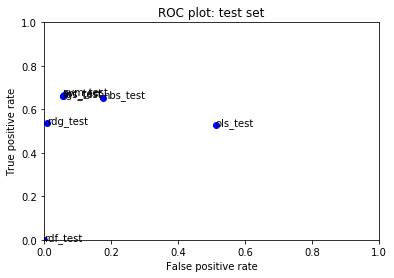

In [79]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [23]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/home/ec2-user/data/toxiccomments_test.csv', my_random_seed=74, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0          72          10
1          13           1
2          16           0
3          38           3
4           7           1
5          16           2
6          31           4
7           6       

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [24]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.4837102713431355


In [25]:
raw_data.head()

,id,comment_text,word_count,punc_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1


In [26]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,True
2,00013b17ad220c46,False
3,00017563c3f7919a,True
4,00017695ad8997eb,True


In [27]:
my_submission.shape

(153164, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/home/ec2-user/data/toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation